# Music & Mental Health Data Analysis: Modeling


## Description  
This notebook explores various predictive models and evaluates the performance in predicting the target binaryt variable, `improved`.

## Objectives  
- Load and review the dataset after feature engineering and sampling
- Explore predictive models:
  - Logistic Regression
  - Random Forest Classifier
  - Gradient Boosting Classifier
- For each, set up baseline model and evaluate on both balanced and imbalanced data.
- Perform cross-validation and hyperparameter tuning
- Compare model performances and choose production model

## Dataset Source  
- [Music & Mental Health Dataset on Kaggle](https://www.kaggle.com/datasets/catherinerasgaitis/mxmh-survey-results)

## Notes  
- This notebook is part of a larger data science pipeline aimed at exploring the relationship between music preferences and mental health indicators  
- All modeling and evaluation methods will be documented

In [261]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import pandas as pd
pd.set_option('display.max_columns', 0)
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Modeling
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV, GridSearchCV, validation_curve, StratifiedKFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Metrics
from sklearn.metrics import (
    classification_report, precision_recall_curve, roc_curve, auc, matthews_corrcoef, make_scorer, precision_score, recall_score, f1_score
)
from sklearn.inspection import permutation_importance
import shap

from music_and_mental_health_survey_analysis.config import (
    PROCESSED_DATA_DIR, MODELING_EVALUATIONS_DIR
)

In [167]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [168]:
RANDOM_STATE = 42

# Load and Review Dataset

In [169]:
df = pd.read_csv(PROCESSED_DATA_DIR / 'sampled.csv')
df.head()

,Age,Hours per day,BPM,While working,Instrumentalist,Composer,Exploratory,Foreign languages,Frequency [Classical],Frequency [Country],Frequency [EDM],Frequency [Folk],Frequency [Gospel],Frequency [Hip hop],Frequency [Jazz],Frequency [K pop],Frequency [Latin],Frequency [Lofi],Frequency [Metal],Frequency [Pop],Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Anxiety,Depression,Insomnia,OCD,Primary streaming service_I do not use a streaming service.,Primary streaming service_Other streaming service,Primary streaming service_Pandora,Primary streaming service_Spotify,Primary streaming service_YouTube Music,Fav genre_Country,Fav genre_EDM,Fav genre_Folk,Fav genre_Gospel,Fav genre_Hip hop,Fav genre_Jazz,Fav genre_K pop,Fav genre_Latin,Fav genre_Lofi,Fav genre_Metal,Fav genre_Pop,Fav genre_R&B,Fav genre_Rap,Fav genre_Rock,Fav genre_Video game music,improved
0,18.0,3.0,156.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,0.0,3.0,3.0,1.0,0.0,3.0,2.0,3.0,0.0,2.0,3,0,1,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,63.0,1.5,119.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,1.0,2.0,1.0,3.0,1.0,2.0,1.0,0.0,2.0,2.0,1.0,3.0,1.0,7,2,2,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,18.0,4.0,132.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,1.0,1.0,3.0,0.0,2.0,2.0,1.0,0.0,1.0,1.0,3.0,7,7,10,2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,61.0,2.5,84.0,1.0,0.0,1.0,1.0,1.0,2.0,0.0,0.0,1.0,2.0,0.0,3.0,2.0,3.0,2.0,0.0,2.0,2.0,0.0,0.0,0.0,9,7,3,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,18.0,4.0,107.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,3.0,0.0,3.0,2.0,2.0,0.0,2.0,3.0,3.0,0.0,1.0,7,2,5,9,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [170]:
df.isna().sum()

Age                                                            0
Hours per day                                                  0
BPM                                                            0
While working                                                  0
Instrumentalist                                                0
Composer                                                       0
Exploratory                                                    0
Foreign languages                                              0
Frequency [Classical]                                          0
Frequency [Country]                                            0
Frequency [EDM]                                                0
Frequency [Folk]                                               0
Frequency [Gospel]                                             0
Frequency [Hip hop]                                            0
Frequency [Jazz]                                               0
Frequency [K pop]        

In [171]:
any(df.select_dtypes(exclude='number'))

False

In [172]:
df.describe()

,Age,Hours per day,BPM,While working,Instrumentalist,Composer,Exploratory,Foreign languages,Frequency [Classical],Frequency [Country],Frequency [EDM],Frequency [Folk],Frequency [Gospel],Frequency [Hip hop],Frequency [Jazz],Frequency [K pop],Frequency [Latin],Frequency [Lofi],Frequency [Metal],Frequency [Pop],Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Anxiety,Depression,Insomnia,OCD,Primary streaming service_I do not use a streaming service.,Primary streaming service_Other streaming service,Primary streaming service_Pandora,Primary streaming service_Spotify,Primary streaming service_YouTube Music,Fav genre_Country,Fav genre_EDM,Fav genre_Folk,Fav genre_Gospel,Fav genre_Hip hop,Fav genre_Jazz,Fav genre_K pop,Fav genre_Latin,Fav genre_Lofi,Fav genre_Metal,Fav genre_Pop,Fav genre_R&B,Fav genre_Rap,Fav genre_Rock,Fav genre_Video game music,improved
count,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000,968.00000,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000,968.000000
mean,25.039515,3.427787,123.147310,0.784091,0.248967,0.118802,0.708678,0.571281,1.293388,0.657025,0.851240,0.938017,0.261364,1.263430,0.902893,0.572314,0.484504,0.964876,1.213843,2.089876,1.089876,1.231405,2.207645,1.157025,5.724174,4.794421,3.452479,2.179752,0.069215,0.046488,0.008264,0.670455,0.088843,0.02376,0.034091,0.026860,0.004132,0.032025,0.020661,0.025826,0.003099,0.009298,0.090909,0.120868,0.032025,0.020661,0.308884,0.039256,0.500000
std,11.103370,2.562055,28.510792,0.411664,0.432638,0.323722,0.454607,0.495149,0.983145,0.852111,1.026323,0.998593,0.600650,1.040953,0.930286,0.908957,0.780957,0.978996,1.149945,0.881371,1.020565,1.033145,1.021619,1.067588,2.844351,3.048741,3.063920,2.642177,0.253950,0.210647,0.090579,0.470291,0.284664,0.15238,0.181557,0.161756,0.064183,0.176157,0.142321,0.158699,0.055613,0.096024,0.287628,0.326142,0.176157,0.142321,0.462272,0.194304,0.500258
min,10.000000,0.100000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,1.976641,105.649264,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.000000,0.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,21.338773,2.944201,120.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.000000,3.000000,1.000000,6.000000,5.000000,3.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000
75%,27.000000,4.679194,140.000000,1.000000,0.000000,0.000000,1.000000,1.000000,2.000000,1.000000,2.000000,2.000000,0.000000,2.000000,2.000000,1.000000,1.000000,2.000000,2.000000,3.000000,2.000000,2.000000,3.000000,2.000000,8.000000,7.000000,6.000000,3.250000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0

## Load un-balanced dataset for comparison

In [173]:
unbalanced_df = pd.read_csv(PROCESSED_DATA_DIR / 'features.csv')
unbalanced_df.head()

,Age,Hours per day,BPM,While working,Instrumentalist,Composer,Exploratory,Foreign languages,Frequency [Classical],Frequency [Country],Frequency [EDM],Frequency [Folk],Frequency [Gospel],Frequency [Hip hop],Frequency [Jazz],Frequency [K pop],Frequency [Latin],Frequency [Lofi],Frequency [Metal],Frequency [Pop],Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Anxiety,Depression,Insomnia,OCD,improved,Primary streaming service_I do not use a streaming service.,Primary streaming service_Other streaming service,Primary streaming service_Pandora,Primary streaming service_Spotify,Primary streaming service_YouTube Music,Fav genre_Country,Fav genre_EDM,Fav genre_Folk,Fav genre_Gospel,Fav genre_Hip hop,Fav genre_Jazz,Fav genre_K pop,Fav genre_Latin,Fav genre_Lofi,Fav genre_Metal,Fav genre_Pop,Fav genre_R&B,Fav genre_Rap,Fav genre_Rock,Fav genre_Video game music
0,18.0,3.0,156.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,0.0,3.0,3.0,1.0,0.0,3.0,2.0,3.0,0.0,2.0,3,0,1,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,63.0,1.5,119.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,1.0,2.0,1.0,3.0,1.0,2.0,1.0,0.0,2.0,2.0,1.0,3.0,1.0,7,2,2,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,18.0,4.0,132.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,1.0,1.0,3.0,0.0,2.0,2.0,1.0,0.0,1.0,1.0,3.0,7,7,10,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,61.0,2.5,84.0,1.0,0.0,1.0,1.0,1.0,2.0,0.0,0.0,1.0,2.0,0.0,3.0,2.0,3.0,2.0,0.0,2.0,2.0,0.0,0.0,0.0,9,7,3,3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,18.0,4.0,107.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,3.0,0.0,3.0,2.0,2.0,0.0,2.0,3.0,3.0,0.0,1.0,7,2,5,9,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [174]:
# Check for missing values

any(unbalanced_df.isna().sum() > 0)

False

In [175]:
# Check for non-numeric values

any(unbalanced_df.select_dtypes(exclude='number'))

False

In [176]:
unbalanced_df.describe()

,Age,Hours per day,BPM,While working,Instrumentalist,Composer,Exploratory,Foreign languages,Frequency [Classical],Frequency [Country],Frequency [EDM],Frequency [Folk],Frequency [Gospel],Frequency [Hip hop],Frequency [Jazz],Frequency [K pop],Frequency [Latin],Frequency [Lofi],Frequency [Metal],Frequency [Pop],Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Anxiety,Depression,Insomnia,OCD,improved,Primary streaming service_I do not use a streaming service.,Primary streaming service_Other streaming service,Primary streaming service_Pandora,Primary streaming service_Spotify,Primary streaming service_YouTube Music,Fav genre_Country,Fav genre_EDM,Fav genre_Folk,Fav genre_Gospel,Fav genre_Hip hop,Fav genre_Jazz,Fav genre_K pop,Fav genre_Latin,Fav genre_Lofi,Fav genre_Metal,Fav genre_Pop,Fav genre_R&B,Fav genre_Rap,Fav genre_Rock,Fav genre_Video game music
count,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000
mean,24.939580,3.484685,123.226294,0.795804,0.321678,0.172028,0.717483,0.552448,1.334266,0.823776,1.025175,1.019580,0.379021,1.398601,1.033566,0.735664,0.605594,1.079720,1.213986,2.065734,1.269930,1.339860,2.081119,1.254545,5.840559,4.806993,3.717483,2.613986,0.753846,0.092308,0.067133,0.012587,0.626573,0.131469,0.034965,0.048951,0.040559,0.006993,0.047552,0.027972,0.036364,0.004196,0.013986,0.117483,0.159441,0.047552,0.027972,0.254545,0.058741
std,11.602233,2.618192,29.571452,0.403395,0.467447,0.377669,0.450539,0.497590,0.989518,0.924151,1.050241,1.012337,0.694401,1.028582,0.938736,1.003524,0.863821,1.026577,1.131581,0.918157,1.057787,1.052151,1.031232,1.072754,2.769842,3.008709,3.059387,2.813896,0.431071,0.289662,0.250427,0.111563,0.484053,0.338149,0.183820,0.215917,0.197405,0.083390,0.212966,0.165008,0.187324,0.064684,0.117515,0.322220,0.366343,0.212966,0.165008,0.435910,0.235304
min,10.000000,0.100000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,2.000000,104.700000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.500000,0.000000,4.000000,2.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,21.000000,3.000000,120.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,6.000000,5.000000,3.000000,2.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,27.000000,5.000000,140.000000,1.000000,1.000000,0.000000,1.000000,1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000,2.000000,3.000000,2.000000,2.000000,3.000000,2.000000,8.000000,7.000000,6.000000,4.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0

# Modeling

## Logistic Regression

### Base Model

#### Imbalanced Dataset

In [177]:
# Split data

X = unbalanced_df.drop(labels=['improved'], axis=1)
y = unbalanced_df['improved']

X_imb_train, X_imb_test, y_imb_train, y_imb_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

In [178]:
# Set up scaling for continuous features

numeric_cols = ['Age', 'BPM', 'Hours per day']
categorical_cols = [col for col in X.columns if col not in numeric_cols]

preprocessor = ColumnTransformer(
    transformers = [
        ('numeric', StandardScaler(), numeric_cols),
        ('categorical', 'passthrough', categorical_cols)
    ]
)

In [179]:
# Set up pipeline

steps = [
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=3000))
]

imb_pipeline = Pipeline(steps=steps)

# Fit model

imb_pipeline.fit(X_imb_train, y_imb_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  ['Age', 'BPM',
                                                   'Hours per day']),
                                                 ('categorical', 'passthrough',
                                                  ['While working',
                                                   'Instrumentalist',
                                                   'Composer', 'Exploratory',
                                                   'Foreign languages',
                                                   'Frequency [Classical]',
                                                   'Frequency [Country]',
                                                   'Frequency [EDM]',
                                                   'Frequency [Folk]',
                                                   'Frequency [Gospel]',
                                                   'Frequency [Hip hop]',
                                                   'Fr...
                                                   'Frequency [Video game '
                                                   'music]',
                                                   'Anxiety', 'Depression',
                                                   'Insomnia', 'OCD',
                                                   'Primary streaming '
                                                   'service_I do not use a '
                                                   'streaming service.',
                                                   'Primary streaming '
                                                   'service_Other streaming '
                                                   'service',
                                                   'Primary streaming '
                                                   'service_Pandora',
                                                   'Primary streaming '
                                                   'service_Spotify',
                                                   'Primary streaming '
                                                   'service_YouTube Music', ...])])),
                ('classifier', LogisticRegression(max_iter=3000))])

In [180]:
# Test model on test data

y_imb_pred = imb_pipeline.predict(X_imb_test)

In [181]:
# Print classification report

imb_report = classification_report(y_imb_test, y_imb_pred)
print(imb_report)

              precision    recall  f1-score   support

         0.0       0.28      0.14      0.19        35
         1.0       0.76      0.88      0.82       108

    accuracy                           0.70       143
   macro avg       0.52      0.51      0.50       143
weighted avg       0.64      0.70      0.66       143



In [182]:
# 5-fold cross validation

kf = KFold(shuffle=True, random_state=RANDOM_STATE)

scores = cross_val_score(estimator=imb_pipeline, X=X_imb_train, y=y_imb_train, scoring='recall', cv=kf)
print(f"Cross-validated Recall: {np.mean(scores)}")

Cross-validated Recall: 0.9124213135939181


#### Balanced Dataset

In [183]:
# Split data

X = df.drop(labels=['improved'], axis=1)
y = df['improved']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

In [184]:
# Set up pipeline

steps = [
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=3000))
]

pipeline = Pipeline(steps)

# Fit model

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  ['Age', 'BPM',
                                                   'Hours per day']),
                                                 ('categorical', 'passthrough',
                                                  ['While working',
                                                   'Instrumentalist',
                                                   'Composer', 'Exploratory',
                                                   'Foreign languages',
                                                   'Frequency [Classical]',
                                                   'Frequency [Country]',
                                                   'Frequency [EDM]',
                                                   'Frequency [Folk]',
                                                   'Frequency [Gospel]',
                                                   'Frequency [Hip hop]',
                                                   'Fr...
                                                   'Frequency [Video game '
                                                   'music]',
                                                   'Anxiety', 'Depression',
                                                   'Insomnia', 'OCD',
                                                   'Primary streaming '
                                                   'service_I do not use a '
                                                   'streaming service.',
                                                   'Primary streaming '
                                                   'service_Other streaming '
                                                   'service',
                                                   'Primary streaming '
                                                   'service_Pandora',
                                                   'Primary streaming '
                                                   'service_Spotify',
                                                   'Primary streaming '
                                                   'service_YouTube Music', ...])])),
                ('classifier', LogisticRegression(max_iter=3000))])

In [185]:
# Test model on test data

y_pred = pipeline.predict(X_test)

In [186]:
# Print classification report

balanced_report = classification_report(y_test, y_pred)
print(balanced_report)

              precision    recall  f1-score   support

         0.0       0.74      0.80      0.77        92
         1.0       0.81      0.75      0.78       102

    accuracy                           0.77       194
   macro avg       0.77      0.77      0.77       194
weighted avg       0.78      0.77      0.77       194



In [187]:
# 5-fold cross validation

scores = cross_val_score(estimator=pipeline, X=X_train, y=y_train, scoring='recall', cv=kf)
print(f"Cross-validated Recall: {np.mean(scores)}")

Cross-validated Recall: 0.7009759148639375


#### Summary
- Our goal is to **identify as many instances of the positive class as possible** (people who showed improvement) in order to understand what music characteristics are associated with improvement.
  Therefore we prioritize **recall**, which measures the proportion of true positives correctly identified
- While the logistic regression model trained on **balanced data** performs better overall at predicting both classes, the model trained on **imbalanced data** achieves a **higher recall** for the positive class.
- As a result, a **logistic regression model trained on imbalanced data** will serve as our baseline since it best aligns with our objective of maximizing recall for the positive class.

### Hyperparameter tuning

In [188]:
# Hyperparameters

param_grid = [
    {
        'classifier__solver': ['newton-cholesky'],
        'classifier__penalty': ['l2', None],
        'classifier__C': np.logspace(-3, 2, num=10)
    },
    {
        'classifier__solver': ['liblinear'],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__C': np.logspace(-3, 2, num=10)
    },
    {
        'classifier__solver': ['lbfgs'],
        'classifier__penalty': ['l2', None],
        'classifier__C': np.logspace(-3, 2, num=10)
    }
]

In [189]:
# Imbalanced dataset

imb_grid_search = GridSearchCV(estimator=imb_pipeline, param_grid=param_grid, cv=kf, n_jobs=-1, scoring='recall')
imb_grid_search.fit(X_imb_train, y_imb_train)

print(f"Best parameters: {imb_grid_search.best_params_}")
print(f"Best score: {imb_grid_search.best_score_}")

/home/arsen/anaconda3/envs/music_mental_health_analysis/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/arsen/anaconda3/envs/music_mental_health_analysis/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/arsen/anaconda3/envs/music_mental_health_analysis/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/arsen/anaconda3/envs/music_mental_health_analysis/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/arsen/anaconda3/envs/music_mental_health_analysis/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1207: Use

Best parameters: {'classifier__C': np.float64(0.001), 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cholesky'}
Best score: 1.0


/home/arsen/anaconda3/envs/music_mental_health_analysis/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/arsen/anaconda3/envs/music_mental_health_analysis/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/arsen/anaconda3/envs/music_mental_health_analysis/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


In [190]:
# Test best model on test data

best_imb_model = imb_grid_search.best_estimator_.named_steps['classifier']
y_imb_pred = best_imb_model.predict(X_imb_test)

print(classification_report(y_imb_test, y_imb_pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        35
         1.0       0.76      1.00      0.86       108

    accuracy                           0.76       143
   macro avg       0.38      0.50      0.43       143
weighted avg       0.57      0.76      0.65       143



In [191]:
y_imb_pred

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1.])

Since we used the **imbalanced data** to train our model, it is achieving a **high recall and f1-score** by predicting solely the positive class. We'll instead retrain the model on the **balanced data** to avoid developing a dummy classifier.

In [192]:
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=kf, n_jobs=-1, scoring='recall')
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

/home/arsen/anaconda3/envs/music_mental_health_analysis/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/arsen/anaconda3/envs/music_mental_health_analysis/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/arsen/anaconda3/envs/music_mental_health_analysis/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/arsen/anaconda3/envs/music_mental_health_analysis/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/arsen/anaconda3/envs/music_mental_health_analysis/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1207: Use

Best parameters: {'classifier__C': np.float64(7.742636826811277), 'classifier__penalty': 'l2', 'classifier__solver': 'newton-cholesky'}
Best score: 0.7351413384630962


/home/arsen/anaconda3/envs/music_mental_health_analysis/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


In [193]:
# Test best model on test data

best_model = grid_search.best_estimator_.named_steps['classifier']
y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.47      1.00      0.64        92
         1.0       0.00      0.00      0.00       102

    accuracy                           0.47       194
   macro avg       0.24      0.50      0.32       194
weighted avg       0.22      0.47      0.31       194



In [194]:
y_pred

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])

The model trained on **balanced data** performed contrary to the model trained on **imbalanced data** and predicted solely the negative class. This may be due to way in which the data was oversampled using SMOTE-NC.
We'll instead explore the models' abilities to predict the probability of a respondent improving.

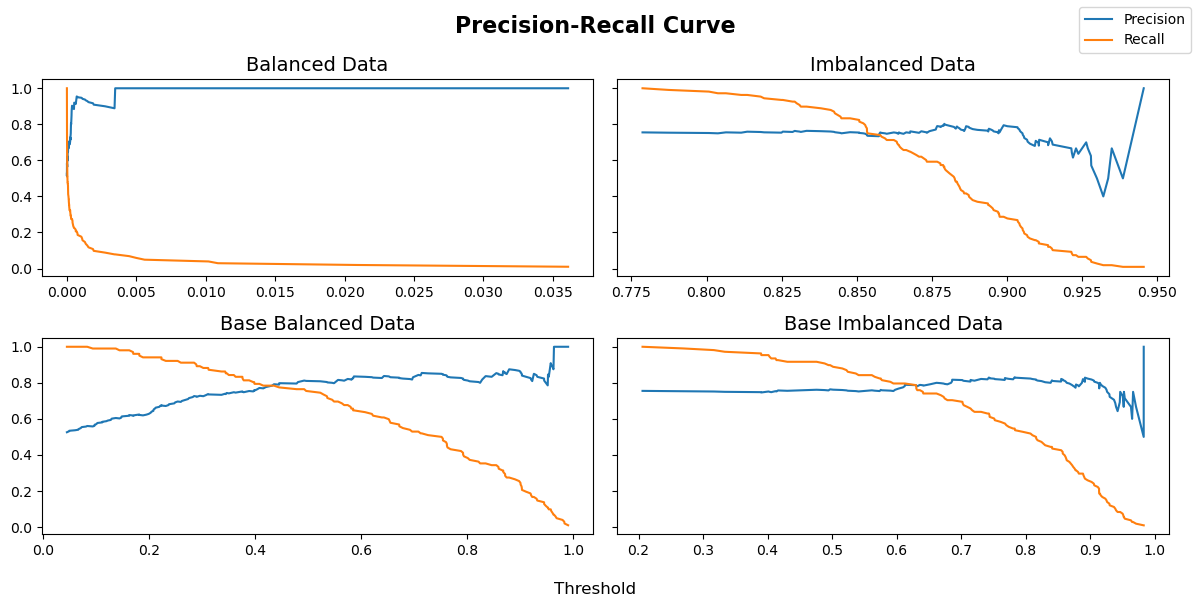

In [195]:
# Predict probability

y_prob = best_model.predict_proba(X_test)
y_imb_prob = best_imb_model.predict_proba(X_imb_test)

base_prob = pipeline.predict_proba(X_test)
base_imb_prob = imb_pipeline.predict_proba(X_imb_test)

# Visualize precision recall cruve

precision, recall, thresholds = precision_recall_curve(y_test, y_prob[:, 1])
imb_precision, imb_recall, imb_thresholds = precision_recall_curve(y_imb_test, y_imb_prob[:, 1])

b_precision, b_recall, b_thresholds = precision_recall_curve(y_test, base_prob[:, 1])
b_imb_precision, b_imb_recall, b_imb_thresholds = precision_recall_curve(y_imb_test, base_imb_prob[:, 1])

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 6), sharey=True)
axes = ax.flatten()
fig.suptitle('Precision-Recall Curve', fontsize=16, fontweight='bold')

axes[0].plot(thresholds, precision[:-1], label='Precision')
axes[0].plot(thresholds, recall[:-1], label='Recall')
axes[0].set_title('Balanced Data', fontsize=14)

axes[1].plot(imb_thresholds, imb_precision[:-1])
axes[1].plot(imb_thresholds, imb_recall[:-1])
axes[1].set_title('Imbalanced Data', fontsize=14)

axes[2].plot(b_thresholds, b_precision[:-1])
axes[2].plot(b_thresholds, b_recall[:-1])
axes[2].set_title('Base Balanced Data', fontsize=14)

axes[3].plot(b_imb_thresholds, b_imb_precision[:-1])
axes[3].plot(b_imb_thresholds, b_imb_recall[:-1])
axes[3].set_title('Base Imbalanced Data', fontsize=14)

fig.legend()
fig.supxlabel('Threshold')

plt.tight_layout()
plt.savefig(MODELING_EVALUATIONS_DIR / 'logistic_precision_recall_curve.png', bbox_inches='tight')
plt.show()

- The model trained on balanced data is confident when it predicts, but **rarely does so** for the positive class unless the threshold is **very low**.
  - Positive class predictions are rare, so **recall is highly sensitive to threshold**.
  - A very low threshold must be used to **retain recall**.
- The model trained on imbalanced data maintains a **steady precision** and **steadily decreasing recall** as the threshold increases.
  - Model is **better calibrated** since predictions are more evenly distributed across thresholds.
  - **Lack of precision gain** suggests the model isn't finding strong signals for confident **positive class predictions**.
- The **base model trained on balanced data** is better calibrated with a good **recall-precision tradeoff** and **interpretable behavior**.

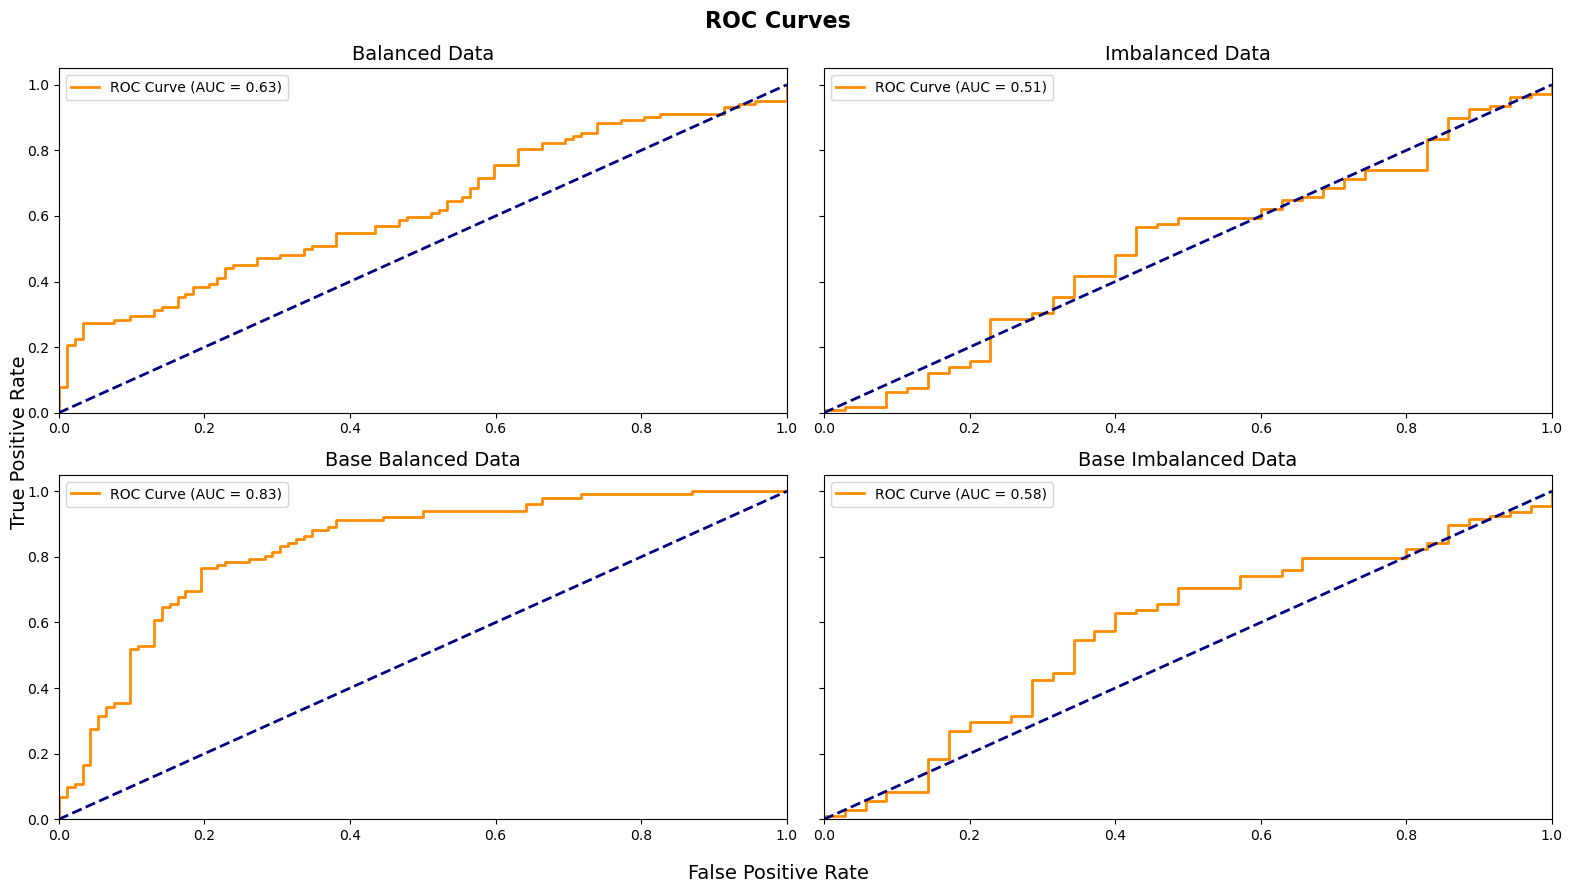

In [196]:
# Plot roc curves

fpr, tpr, thresholds = roc_curve(y_test, y_prob[:, 1])
imb_fpr, imb_tpr, imb_thresholds = roc_curve(y_imb_test, y_imb_prob[:, 1])

b_fpr, b_tpr, b_thresholds = roc_curve(y_test, base_prob[:, 1])
b_imb_fpr, b_imb_tpr, b_imb_thresholds = roc_curve(y_imb_test, base_imb_prob[:, 1])

roc_auc = auc(fpr, tpr)
imb_roc_auc = auc(imb_fpr, imb_tpr)

b_roc_auc = auc(b_fpr, b_tpr)
b_imb_roc_auc = auc(b_imb_fpr, b_imb_tpr)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 9), sharey=True)
axes = ax.flatten()

fig.suptitle('ROC Curves', fontsize=16, fontweight='bold')

axes[0].set_title('Balanced Data', fontsize=14)
axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
axes[0].plot([0, 1], [0, 1], linestyle='--', color='navy', lw=2)
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].legend()

axes[1].set_title('Imbalanced Data', fontsize=14)
axes[1].plot(imb_fpr, imb_tpr, color='darkorange', lw=2, label=f"ROC Curve (AUC = {imb_roc_auc:.2f})")
axes[1].plot([0, 1], [0, 1], linestyle='--', color='navy', lw=2)
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].legend()

axes[2].set_title('Base Balanced Data', fontsize=14)
axes[2].plot(b_fpr, b_tpr, color='darkorange', lw=2, label=f"ROC Curve (AUC = {b_roc_auc:.2f})")
axes[2].plot([0, 1], [0, 1], linestyle='--', color='navy', lw=2)
axes[2].set_xlim([0.0, 1.0])
axes[2].set_ylim([0.0, 1.05])
axes[2].legend()

axes[3].set_title('Base Imbalanced Data', fontsize=14)
axes[3].plot(b_imb_fpr, b_imb_tpr, color='darkorange', lw=2, label=f"ROC Curve (AUC = {b_imb_roc_auc:.2f})")
axes[3].plot([0, 1], [0, 1], linestyle='--', color='navy', lw=2)
axes[3].set_xlim([0.0, 1.0])
axes[3].set_ylim([0.0, 1.05])
axes[3].legend()

fig.supxlabel('False Positive Rate', fontsize=14)
fig.supylabel('True Positive Rate', fontsize=14)

plt.tight_layout()
plt.savefig(MODELING_EVALUATIONS_DIR / 'logistic_roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

- The model trained on balanced data has a **higher AUC** than the model trained on imbalanced data, implying it has more predictive power.
  - An **AUC of 0.63** suggests weak but non-trivial discriminative power.
- The highest performing model is the **base model trained on balanced data** with an **AUC of 0.83**.

## Random Forest

### Base Model

#### Imbalanced Dataset

In [197]:
# Initialize and fit random forest classifier model

rf_imb = RandomForestClassifier(random_state=RANDOM_STATE)

rf_imb.fit(X_imb_train, y_imb_train)

RandomForestClassifier(random_state=42)

In [198]:
# Apply model to test data and evaluate

y_imb_pred = rf_imb.predict(X_imb_test)

print(classification_report(y_imb_test, y_imb_pred))

              precision    recall  f1-score   support

         0.0       0.33      0.03      0.05        35
         1.0       0.76      0.98      0.85       108

    accuracy                           0.75       143
   macro avg       0.55      0.51      0.45       143
weighted avg       0.65      0.75      0.66       143



In [199]:
# Calculate matthew correlation coefficient

imb_mcc = matthews_corrcoef(y_imb_test, y_imb_pred)

print(f"Matthew's Correlation Coefficient: {imb_mcc:.2f}")

Matthew's Correlation Coefficient: 0.03


In [200]:
# Average f1 score from 5 fold cross validation

print(f"Average 5-fold cross validation f1-score: {np.mean(cross_val_score(estimator=rf_imb, X=X_imb_train, y=y_imb_train, cv=kf, scoring='f1')):.2f}")

Average 5-fold cross validation f1-score: 0.86


#### Balanced Dataset

In [201]:
# Initialize and fit random forest classifier to balanced data

rf = RandomForestClassifier(random_state=RANDOM_STATE)

rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [202]:
# Use model to predict and evaluate

y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.83      0.75      0.79        92
         1.0       0.79      0.86      0.83       102

    accuracy                           0.81       194
   macro avg       0.81      0.81      0.81       194
weighted avg       0.81      0.81      0.81       194



In [203]:
# Calculate matthew correlation coefficient

mcc = matthews_corrcoef(y_test, y_pred)

print(f"Matthew's Correlation Coefficient: {mcc:.2f}")

Matthew's Correlation Coefficient: 0.62


In [204]:
# 5-Fold cross-validation

print(f"Average 5-fold cross validation f1-score: {np.mean(cross_val_score(estimator=rf, X=X_train, y=y_train, cv=kf, scoring='f1')):.2f}")

Average 5-fold cross validation f1-score: 0.79


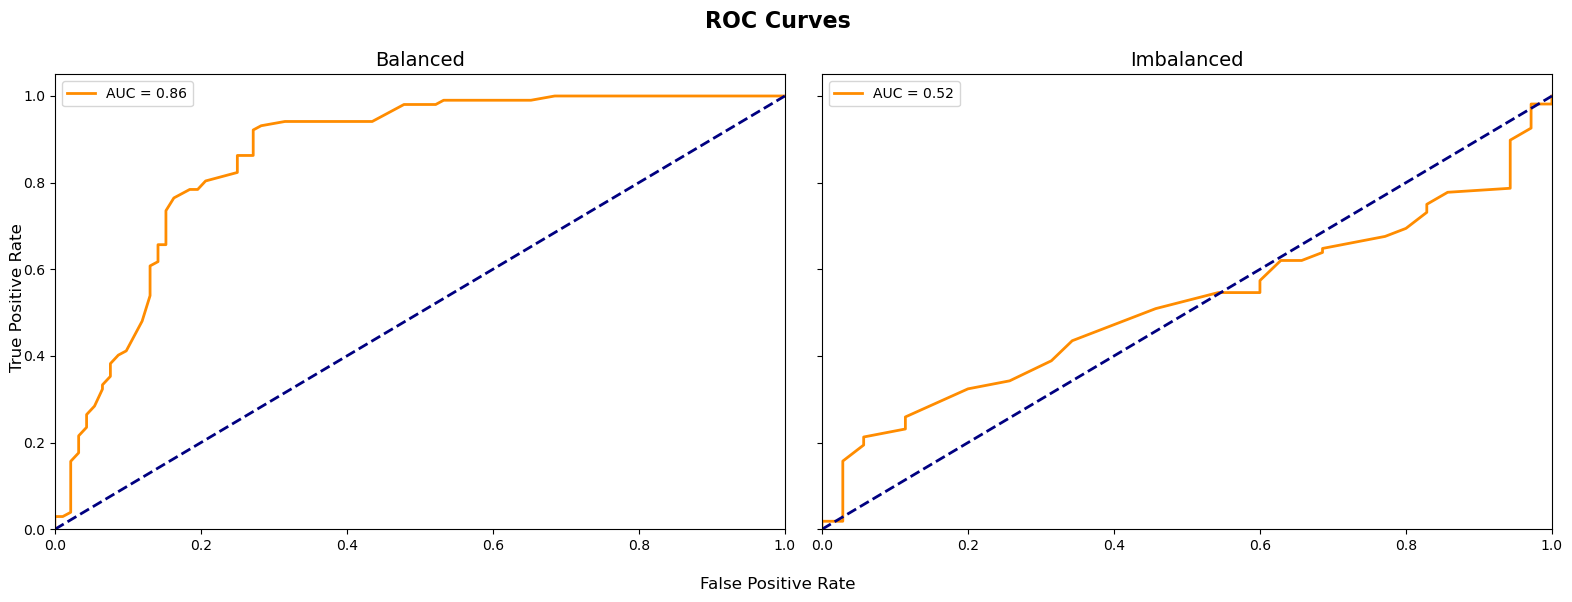

In [205]:
# Plot roc curves

# Predicted probabilities for positive class
y_prob = rf.predict_proba(X=X_test)[:, 1]
y_imb_prob = rf_imb.predict_proba(X=X_imb_test)[:, 1]

# Calculate false positive rates, true positive rates, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
imb_fpr, imb_tpr, imb_thresholds = roc_curve(y_imb_test, y_imb_prob)

# Calculate auc scores
roc_auc = auc(fpr, tpr)
roc_auc_imb = auc(imb_fpr, imb_tpr)

# Plot
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(16, 6))

fig.suptitle('ROC Curves', fontsize=16, fontweight='bold')

ax[0].set_title('Balanced', fontsize=14)
ax[0].plot(fpr, tpr, color='darkorange', lw=2, label=f"AUC = {roc_auc:.2f}")
ax[0].plot([0.0, 1.0], linestyle='--', color='navy', lw=2)
ax[0].set_xlim([0.0, 1.0])
ax[0].set_ylim([0.0, 1.05])
ax[0].legend()

ax[1].set_title('Imbalanced', fontsize=14)
ax[1].plot(imb_fpr, imb_tpr, color='darkorange', lw=2, label=f"AUC = {roc_auc_imb:.2f}")
ax[1].plot([0.0, 1.0], linestyle='--', lw=2, color='navy')
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].legend()

fig.supxlabel('False Positive Rate', fontsize=12)
fig.supylabel('True Positive Rate', fontsize=12)

plt.tight_layout()
plt.savefig(MODELING_EVALUATIONS_DIR / 'random_forest_roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

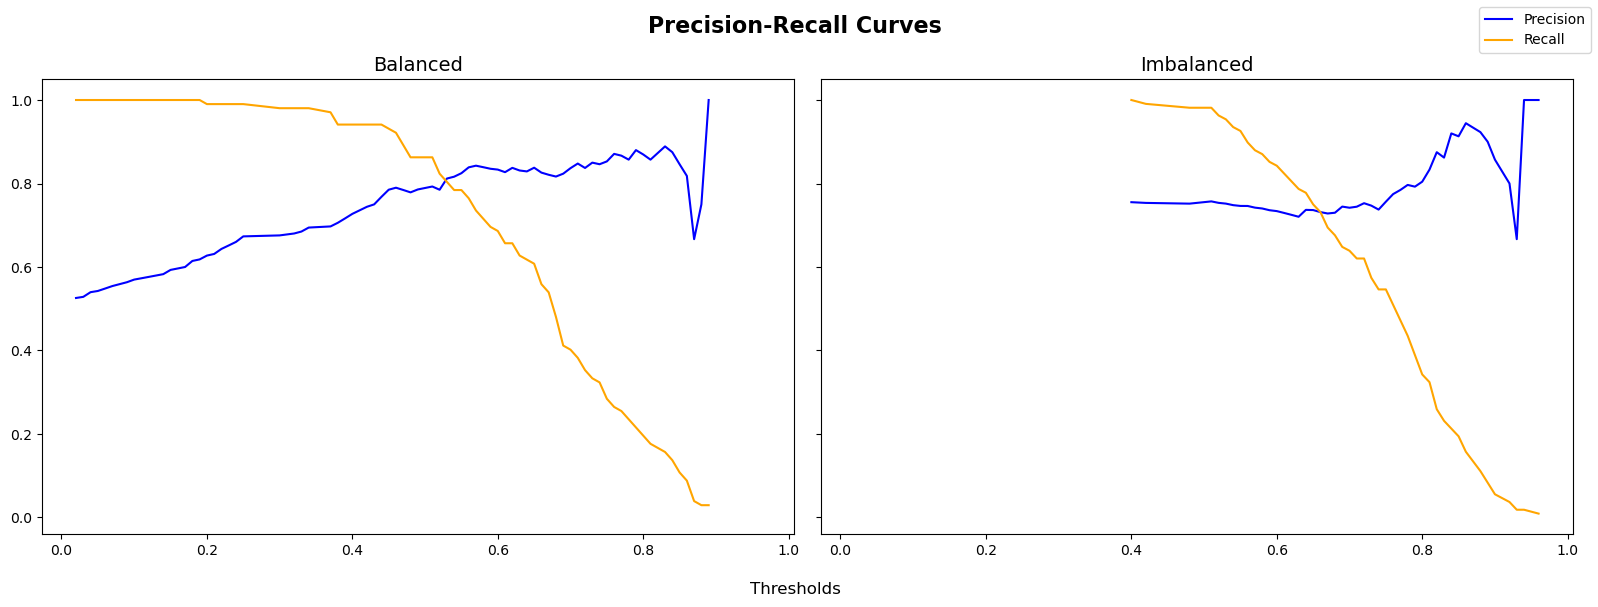

In [206]:
# Plot precision recall curves

precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
imb_precision, imb_recall, imb_thresholds = precision_recall_curve(y_imb_test, y_imb_prob)

fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True, figsize=(16, 6))

fig.suptitle('Precision-Recall Curves', fontsize=16, fontweight='bold')

ax[0].set_title('Balanced', fontsize=14)
ax[0].plot(thresholds, precision[:-1], color='blue', label='Precision')
ax[0].plot(thresholds, recall[:-1], color='orange', label='Recall')

ax[1].set_title('Imbalanced', fontsize=14)
ax[1].plot(imb_thresholds, imb_precision[:-1], color='blue', label='Precision')
ax[1].plot(imb_thresholds, imb_recall[:-1], color='orange', label='Recall')

fig.supxlabel('Thresholds', fontsize=12)
fig.legend(['Precision', 'Recall'])

plt.tight_layout()
plt.show()

#### Summary
- The model trained on **balanced data** scored a much higher *Matthew's Correlation Coefficient*.
- Although the model trained on **imbalanced data** scored a **higher average f1-score** with 5-fold cross validation, it does not perform better than a dummy classifier.
- The model trained on balanced data will act as the **baseline model**.

### Hyperparameter Tuning

In [207]:
# Calcualte validation curve for max_depth

param_range = range(2, 30)
train_scores, val_scores = validation_curve(
    RandomForestClassifier(random_state=RANDOM_STATE),
    X=X_train,
    y=y_train,
    param_name='max_depth',
    param_range=param_range,
    cv=5,
    scoring='roc_auc'
)

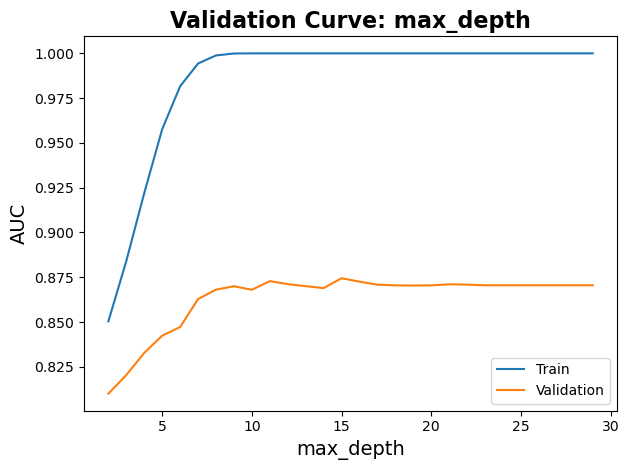

In [208]:
# Plot validation curve for max_depth to estimate ballpark

plt.title('Validation Curve: max_depth', fontsize=16, fontweight='bold')

plt.plot(param_range, np.mean(train_scores, axis=1), label='Train')
plt.plot(param_range, np.mean(val_scores, axis=1), label='Validation')
plt.xlabel('max_depth', fontsize=14)
plt.ylabel('AUC', fontsize=14)
plt.legend()

plt.tight_layout()
plt.savefig(MODELING_EVALUATIONS_DIR / 'random_forest_validation_curve_max_depth.png', dpi=300, bbox_inches='tight')
plt.show()

The ideal range for `max_depth` is around **8-14**.

In [209]:
# Calculate validation curve for min_samples_split

param_range = range(2, 20)

train_scores, val_scores = validation_curve(
    estimator=RandomForestClassifier(random_state=RANDOM_STATE),
    X=X_train,
    y=y_train,
    cv=kf,
    param_name='min_samples_split',
    param_range=param_range,
    scoring='roc_auc'
)

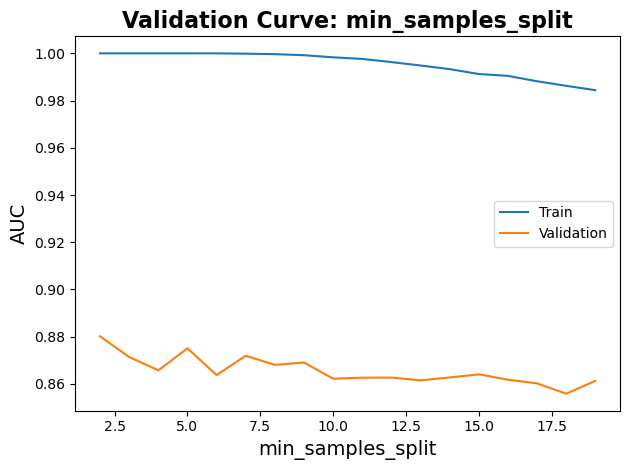

In [210]:
# Plot validation curve for min_samples_split

plt.title('Validation Curve: min_samples_split', fontsize=16, fontweight='bold')

plt.plot(param_range, np.mean(train_scores, axis=1), label='Train')
plt.plot(param_range, np.mean(val_scores, axis=1), label='Validation')

plt.xlabel('min_samples_split', fontsize=14)
plt.ylabel('AUC', fontsize=14)
plt.legend()

plt.tight_layout()
plt.savefig(MODELING_EVALUATIONS_DIR / 'random_forest_validation_curve_min_samples_split.png', dpi=300, bbox_inches='tight')
plt.show()

A *safe* range for `min_samples_split` is **2-7.5** since after 7.5 the AUC gradually diminishes implying **underfitting**.

In [211]:
# Use randomized search for hyperparameters

param_dist = {
    'max_depth': np.arange(start=5, stop=15, step=1, dtype=int),
    'min_samples_split': np.arange(start=2, stop=8, step=1, dtype=int),
    'max_features': ['sqrt', 'log2'],
    'n_estimators': np.arange(start=100, stop=200, step=1, dtype=int)
}

rf_random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
    param_distributions=param_dist,
    n_jobs=-1,
    cv=kf, scoring='roc_auc',
    random_state=RANDOM_STATE
)

rf_random_search.fit(X_train, y_train)

print(f"Best hyperparameters: {rf_random_search.best_params_}")

Best hyperparameters: {'n_estimators': np.int64(191), 'min_samples_split': np.int64(5), 'max_features': 'sqrt', 'max_depth': np.int64(9)}


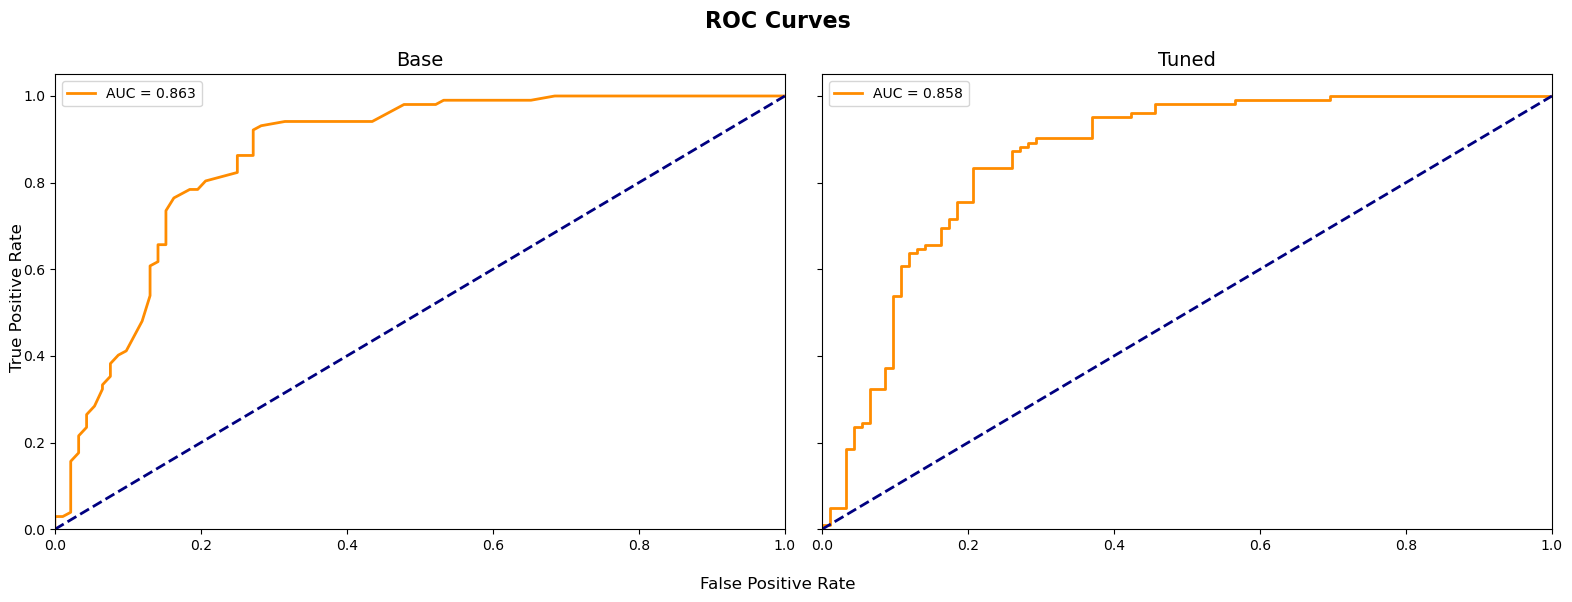

In [212]:
# Plot roc curve to compare with baseline

# Calculate probability of predicting positive class
y_hyper_prob = rf_random_search.best_estimator_.predict_proba(X_test)[:, 1]

# Calculate roc curve
h_fpr, h_tpr, h_thresholds = roc_curve(y_test, y_hyper_prob)

# Calculate auc
h_roc_auc = auc(h_fpr, h_tpr)

# Plot
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(16, 6))

fig.suptitle('ROC Curves', fontsize=16, fontweight='bold')

ax[0].set_title('Base', fontsize=14)
ax[0].plot(fpr, tpr, color='darkorange', lw=2, label=f"AUC = {roc_auc:.3f}")
ax[0].plot([0.0, 1.0], linestyle='--', color='navy', lw=2)
ax[0].set_xlim([0.0, 1.0])
ax[0].set_ylim([0.0, 1.05])
ax[0].legend()

ax[1].set_title('Tuned', fontsize=14)
ax[1].plot(h_fpr, h_tpr, color='darkorange', lw=2, label=f"AUC = {h_roc_auc:.3f}")
ax[1].plot([0.0, 1.0], linestyle='--', lw=2, color='navy')
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].legend()

fig.supxlabel('False Positive Rate', fontsize=12)
fig.supylabel('True Positive Rate', fontsize=12)

plt.tight_layout()
plt.savefig(MODELING_EVALUATIONS_DIR / 'random_forest_roc_base_tuned.png', dpi=300, bbox_inches='tight')
plt.show()

In [213]:
# Predict class labels

y_hyper_pred = rf_random_search.best_estimator_.predict(X_test)

# Print classification report

print(classification_report(y_test, y_hyper_pred))

              precision    recall  f1-score   support

         0.0       0.81      0.79      0.80        92
         1.0       0.82      0.83      0.83       102

    accuracy                           0.81       194
   macro avg       0.81      0.81      0.81       194
weighted avg       0.81      0.81      0.81       194



In [214]:
# Calculate mcc to compare with base model

tuned_mcc = matthews_corrcoef(y_test, y_hyper_pred)

print(f"Base MCC: {mcc:.2f}")
print(f"Tuned MCC: {tuned_mcc:.2f}")

Base MCC: 0.62
Tuned MCC: 0.63


#### Summary

- The difference of 0.005 in **AUC** between the base and tuned models is **statistically insignificant**.
- **Tuned model** has a *slightly* higher MCC compared to the **base model** although it is within the margin of error.
- The base model recall of **0.86** is higher than the tuned model recall of **0.83**.
- The tuned model has greater **per-tree simplicity** which outweights the increase in the **number of estimators**.
  - More trees tend to **reduce variance** and **improve generalization** of the model, therefore the tuned random forest model will be used.

## Gradient Boosting Classifier

### Base Model

#### Imbalanced Dataset

In [215]:
# Initialize and fit gradient boosting classifier

gb_imb = GradientBoostingClassifier(random_state=RANDOM_STATE)

gb_imb.fit(X_imb_train, y_imb_train)

GradientBoostingClassifier(random_state=42)

In [216]:
# Predict class labels and print classification report

y_imb_pred = gb_imb.predict(X_imb_test)

print(classification_report(y_imb_test, y_imb_pred))

              precision    recall  f1-score   support

         0.0       0.17      0.06      0.09        35
         1.0       0.75      0.91      0.82       108

    accuracy                           0.70       143
   macro avg       0.46      0.48      0.45       143
weighted avg       0.61      0.70      0.64       143



In [217]:
scores = cross_val_score(estimator=gb_imb, X=X_imb_train, y=y_imb_train, cv=kf, scoring='f1')

print(f"Average Cross-validated f1-score: {np.mean(scores)}")

Average Cross-validated f1-score: 0.8305005809785028


#### Balanced Dataset

In [218]:
gb = GradientBoostingClassifier(random_state=RANDOM_STATE)

gb.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

In [219]:
y_pred = gb.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.78      0.79      0.78        92
         1.0       0.81      0.79      0.80       102

    accuracy                           0.79       194
   macro avg       0.79      0.79      0.79       194
weighted avg       0.79      0.79      0.79       194



In [220]:
scores = cross_val_score(estimator=gb, X=X_train, y=y_train, cv=kf, scoring='f1')

print(f"Average 5-fold cross validated f1-score: {np.mean(scores)}")

Average 5-fold cross validated f1-score: 0.7403197383936783


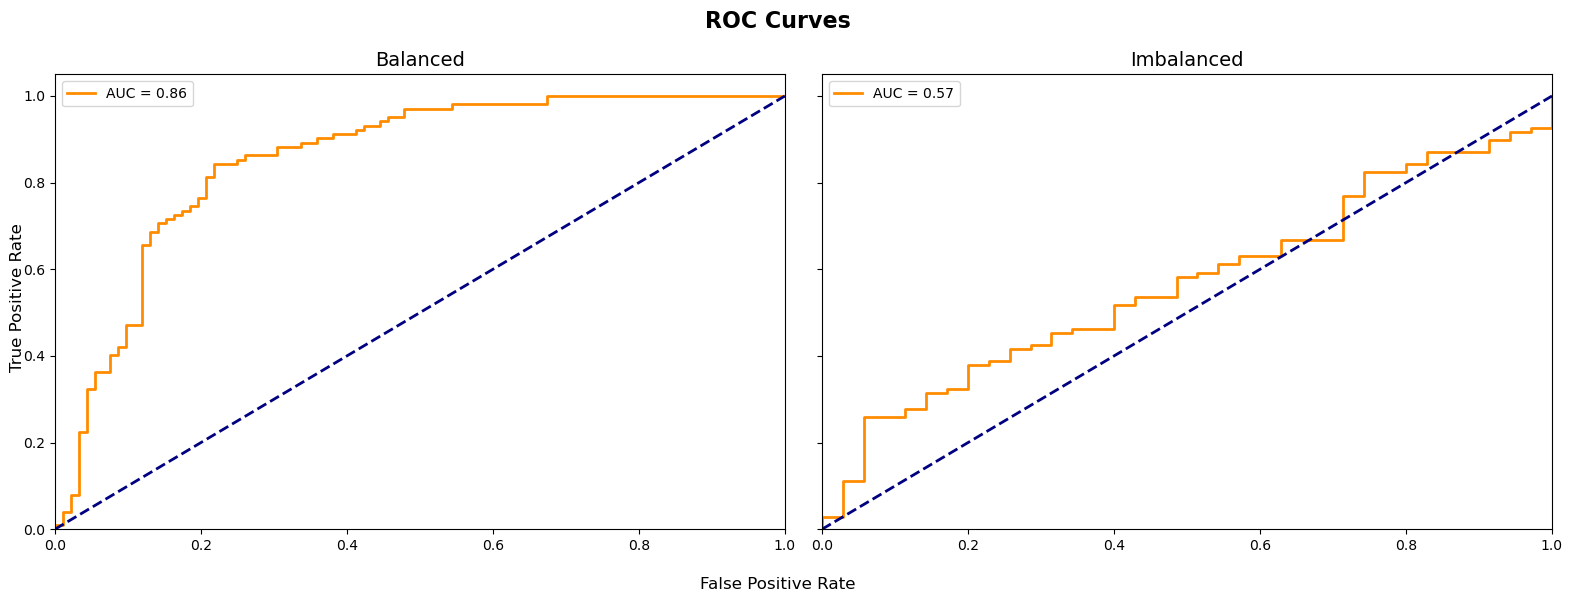

In [221]:
# Plot roc curves

# Predicted probabilities for positive class
y_prob = gb.predict_proba(X=X_test)[:, 1]
y_imb_prob = gb_imb.predict_proba(X=X_imb_test)[:, 1]

# Calculate false positive rates, true positive rates, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
imb_fpr, imb_tpr, imb_thresholds = roc_curve(y_imb_test, y_imb_prob)

# Calculate auc scores
roc_auc = auc(fpr, tpr)
roc_auc_imb = auc(imb_fpr, imb_tpr)

# Plot
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(16, 6))

fig.suptitle('ROC Curves', fontsize=16, fontweight='bold')

ax[0].set_title('Balanced', fontsize=14)
ax[0].plot(fpr, tpr, color='darkorange', lw=2, label=f"AUC = {roc_auc:.2f}")
ax[0].plot([0.0, 1.0], linestyle='--', color='navy', lw=2)
ax[0].set_xlim([0.0, 1.0])
ax[0].set_ylim([0.0, 1.05])
ax[0].legend()

ax[1].set_title('Imbalanced', fontsize=14)
ax[1].plot(imb_fpr, imb_tpr, color='darkorange', lw=2, label=f"AUC = {roc_auc_imb:.2f}")
ax[1].plot([0.0, 1.0], linestyle='--', lw=2, color='navy')
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].legend()

fig.supxlabel('False Positive Rate', fontsize=12)
fig.supylabel('True Positive Rate', fontsize=12)

plt.tight_layout()
plt.savefig(MODELING_EVALUATIONS_DIR / 'gradient_boosting_roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

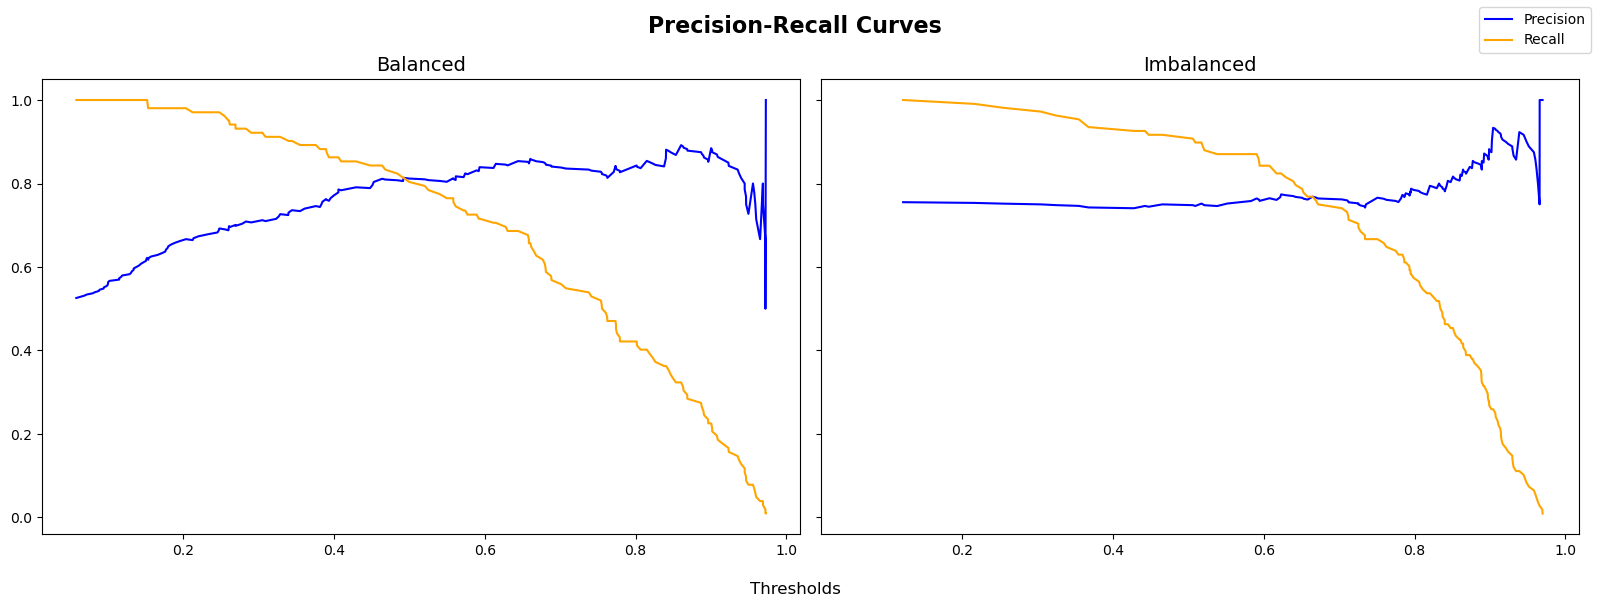

In [222]:
# Plot precision recall curves

precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
imb_precision, imb_recall, imb_thresholds = precision_recall_curve(y_imb_test, y_imb_prob)

fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True, figsize=(16, 6))

fig.suptitle('Precision-Recall Curves', fontsize=16, fontweight='bold')

ax[0].set_title('Balanced', fontsize=14)
ax[0].plot(thresholds, precision[:-1], color='blue', label='Precision')
ax[0].plot(thresholds, recall[:-1], color='orange', label='Recall')

ax[1].set_title('Imbalanced', fontsize=14)
ax[1].plot(imb_thresholds, imb_precision[:-1], color='blue', label='Precision')
ax[1].plot(imb_thresholds, imb_recall[:-1], color='orange', label='Recall')

fig.supxlabel('Thresholds', fontsize=12)
fig.legend(['Precision', 'Recall'])

plt.tight_layout()
plt.savefig(MODELING_EVALUATIONS_DIR / 'gradient_boosting_precision_recall_curves.png', dpi=300, bbox_inches='tight')
plt.show()

#### Summary

- The classifier trained on the **balanced** data scored a **higher AUC** of 0.86 than the model trained on the **imbalanced** data.
- The **precision** of the model trained on balanced data **steadily increases** as the threshold increases, while the precision of the model trained on imbalanced data **remains steady** until higher thresholds.
  - A steadily growing precision means that **more true positives** are captured by the model as the threshold increases.
- The **balanced model** will be used as the base model.

### Hyperparameter Tuning

#### Validation Curves

In [223]:
# Calculate validation curve for learning_rate

param_range = [0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1.0]
train_scores, val_scores = validation_curve(
    estimator=GradientBoostingClassifier(random_state=RANDOM_STATE),
    X=X_train,
    y=y_train,
    param_name='learning_rate',
    param_range=param_range,
    cv=kf,
    scoring='roc_auc'
)

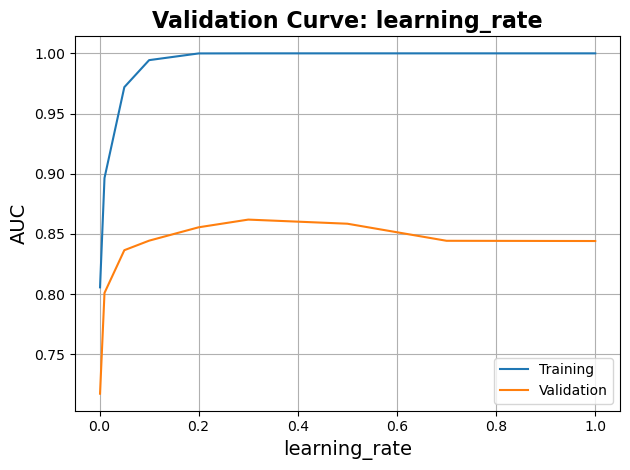

In [224]:
# Plot validation curve

plt.title('Validation Curve: learning_rate', fontsize=16, fontweight='bold')
plt.plot(param_range, np.mean(train_scores, axis=1), label='Training')
plt.plot(param_range, np.mean(val_scores, axis=1), label='Validation')

plt.xlabel('learning_rate', fontsize=14)
plt.ylabel('AUC', fontsize=14)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(MODELING_EVALUATIONS_DIR / 'validation_curve_gradient_boosting_learning_rate.png', dpi=300, bbox_inches='tight')
plt.show()

***Conclusion***: A range between **0.001** and **0.2** will be used for tuning.

In [225]:
# Calculate validation curve for n_estimators

param_range = np.arange(start=50, stop=200, step=1)
train_scores, val_scores = validation_curve(
    estimator=GradientBoostingClassifier(random_state=RANDOM_STATE),
    X=X_train,
    y=y_train,
    param_name='n_estimators',
    param_range=param_range,
    cv=kf,
    scoring='roc_auc'
)

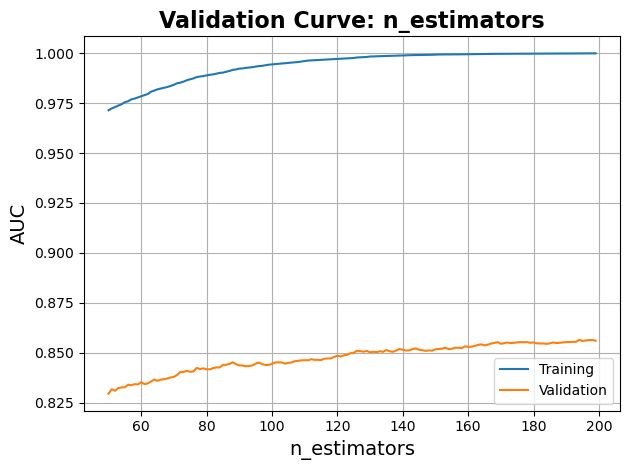

In [226]:
# Plot validation curve

plt.title('Validation Curve: n_estimators', fontsize=16, fontweight='bold')
plt.plot(param_range, np.mean(train_scores, axis=1), label='Training')
plt.plot(param_range, np.mean(val_scores, axis=1), label='Validation')

plt.xlabel('n_estimators', fontsize=14)
plt.ylabel('AUC', fontsize=14)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(MODELING_EVALUATIONS_DIR / 'validation_curve_gradient_boosting_n_estimators.png', dpi=300, bbox_inches='tight')
plt.show()

***Conclusion***: A range between **100 and 160** will be used.

In [227]:
# Calculate validation curve for min_samples_split

param_range = np.arange(start=2, stop=15, step=1)
train_scores, val_scores = validation_curve(
    estimator=GradientBoostingClassifier(random_state=RANDOM_STATE),
    X=X_train,
    y=y_train,
    param_name='min_samples_split',
    param_range=param_range,
    cv=kf,
    scoring='roc_auc'
)

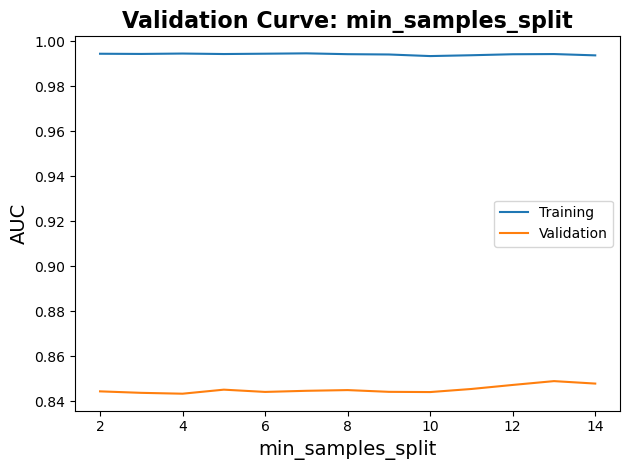

In [228]:
# Plot validation curve

plt.title('Validation Curve: min_samples_split', fontsize=16, fontweight='bold')
plt.plot(param_range, np.mean(train_scores, axis=1), label='Training')
plt.plot(param_range, np.mean(val_scores, axis=1), label='Validation')

plt.xlabel('min_samples_split', fontsize=14)
plt.ylabel('AUC', fontsize=14)
plt.legend()

plt.tight_layout()
plt.savefig(MODELING_EVALUATIONS_DIR / 'validation_curve_gradient_boosting_min_samples_split.png', dpi=300, bbox_inches='tight')
plt.show()

***Conclusion***: `min_samples_split` will not be tuned because of the **negligible** effect on AUC.

In [229]:
# Calculate validation curve for max_depth

param_range = np.arange(start=3, stop=15, step=1)
train_scores, val_scores = validation_curve(
    estimator=GradientBoostingClassifier(random_state=RANDOM_STATE),
    X=X_train,
    y=y_train,
    param_name='max_depth',
    param_range=param_range,
    cv=kf,
    scoring='roc_auc'
)

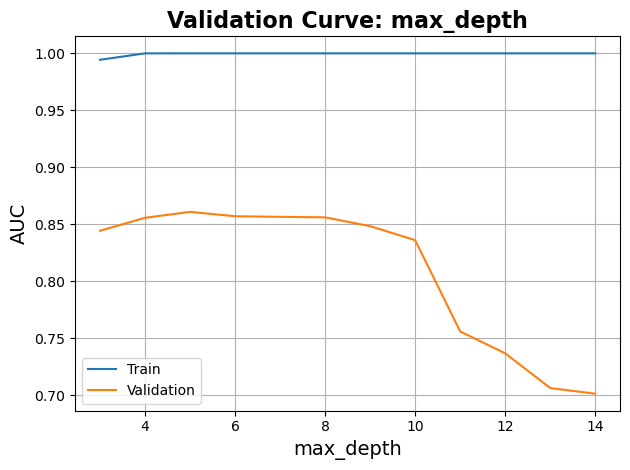

In [230]:
# Plot validation curve for max_depth

plt.title('Validation Curve: max_depth', fontsize=16, fontweight='bold')

plt.plot(param_range, np.mean(train_scores, axis=1), label='Train')
plt.plot(param_range, np.mean(val_scores, axis=1), label='Validation')
plt.grid(True)

plt.xlabel('max_depth', fontsize=14)
plt.ylabel('AUC', fontsize=14)
plt.legend()

plt.tight_layout()
plt.savefig(MODELING_EVALUATIONS_DIR / 'validation_curve_gradient_boosting_max_depth.png', dpi=300, bbox_inches='tight')
plt.show()

***Conclusion***: AUC drops around a max_depth of **5** then dramatically from a max_depth of **8**. Therefore, a range from **3 to 10** will be explored for tuning.

#### Tuning

In [231]:
param_dist = {
    'learning_rate': np.linspace(start=0.001, stop=0.2, num=10),
    'n_estimators': np.arange(start=100, stop=160, step=1),
    'max_depth': np.arange(start=3, stop=10, step=1)
}

gb_random_search = RandomizedSearchCV(
    estimator=GradientBoostingClassifier(random_state=RANDOM_STATE),
    param_distributions=param_dist,
    n_jobs=-1,
    cv=kf,
    scoring='roc_auc',
    random_state=RANDOM_STATE
)

gb_random_search.fit(X_train, y_train)

print(f"Best hyperparameters: {gb_random_search.best_params_}")

Best hyperparameters: {'n_estimators': np.int64(132), 'max_depth': np.int64(5), 'learning_rate': np.float64(0.1557777777777778)}


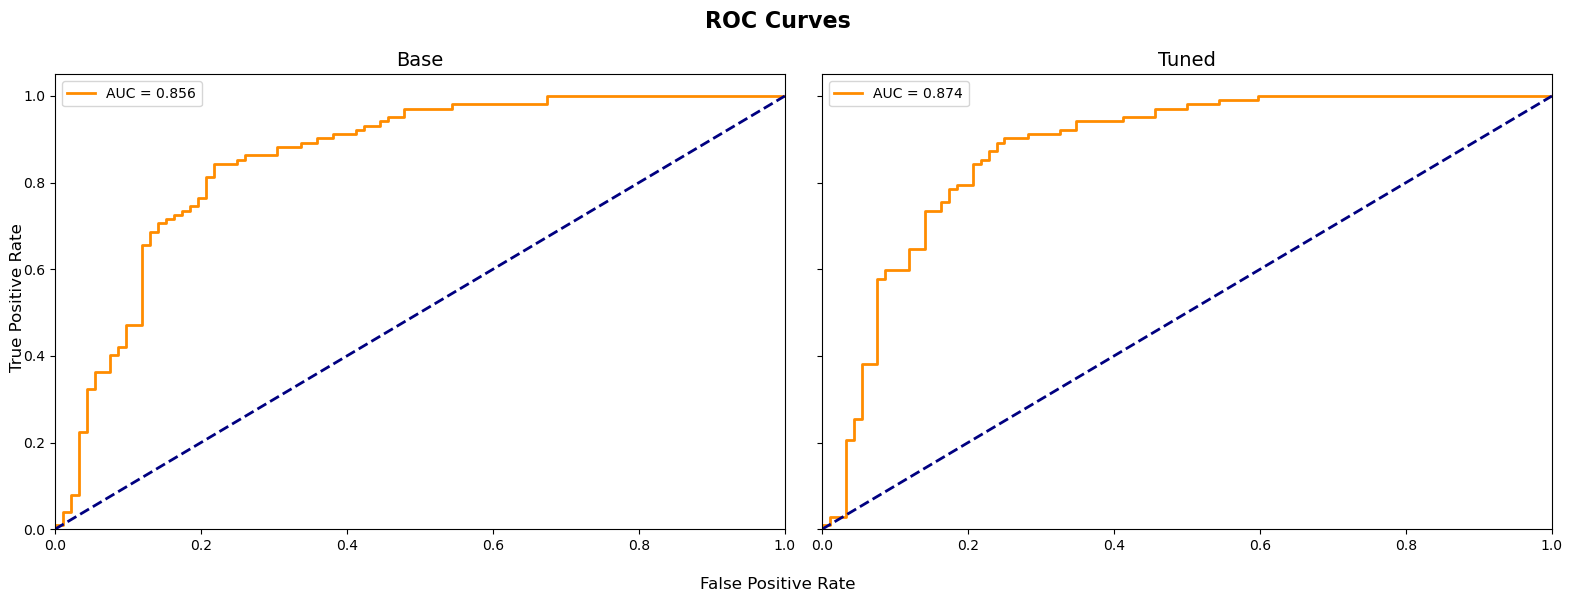

In [232]:
# Plot roc curve to compare with baseline

# Calculate probability of predicting positive class
y_hyper_prob = gb_random_search.best_estimator_.predict_proba(X_test)[:, 1]

# Calculate roc curve
h_fpr, h_tpr, h_thresholds = roc_curve(y_test, y_hyper_prob)

# Calculate auc
h_roc_auc = auc(h_fpr, h_tpr)

# Plot
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(16, 6))

fig.suptitle('ROC Curves', fontsize=16, fontweight='bold')

ax[0].set_title('Base', fontsize=14)
ax[0].plot(fpr, tpr, color='darkorange', lw=2, label=f"AUC = {roc_auc:.3f}")
ax[0].plot([0.0, 1.0], linestyle='--', color='navy', lw=2)
ax[0].set_xlim([0.0, 1.0])
ax[0].set_ylim([0.0, 1.05])
ax[0].legend()

ax[1].set_title('Tuned', fontsize=14)
ax[1].plot(h_fpr, h_tpr, color='darkorange', lw=2, label=f"AUC = {h_roc_auc:.3f}")
ax[1].plot([0.0, 1.0], linestyle='--', lw=2, color='navy')
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].legend()

fig.supxlabel('False Positive Rate', fontsize=12)
fig.supylabel('True Positive Rate', fontsize=12)

plt.tight_layout()
plt.savefig(MODELING_EVALUATIONS_DIR / 'gradient_boosting_roc_base_tuned.png', dpi=300, bbox_inches='tight')
plt.show()

In [233]:
# Predict class labels

y_hyper_pred = gb_random_search.best_estimator_.predict(X_test)

# Print classification report

print(classification_report(y_test, y_hyper_pred))

              precision    recall  f1-score   support

         0.0       0.83      0.78      0.80        92
         1.0       0.81      0.85      0.83       102

    accuracy                           0.82       194
   macro avg       0.82      0.82      0.82       194
weighted avg       0.82      0.82      0.82       194



In [234]:
# Calculate mcc to compare with base model

tuned_mcc = matthews_corrcoef(y_test, y_hyper_pred)

print(f"Base MCC: {matthews_corrcoef(y_test, y_pred):.2f}")
print(f"Tuned MCC: {tuned_mcc:.2f}")

Base MCC: 0.59
Tuned MCC: 0.64


#### Summary
- The **tuned** gradient boosting classifier model performed overall **better** than the base model as measured by AUC and MCC.
- It has greater **per-tree simplicity** since it has a `max_depth` of 5.
- The tuned gradient boosting classifier will be used.

# Compare Models

We will compare the following models:
- Base Logistic Regression
- Tuned Random Forest Classifier
- Tuned Gradient Boosting Classifier

In [235]:
# Set up cross-validation

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

In [236]:
# Split data

X = df.drop(labels=['improved'], axis=1)
X_imb = unbalanced_df.drop(labels=['improved'], axis=1)

y = df['improved']
y_imb = unbalanced_df['improved']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y)
X_imb_train, X_imb_test, y_imb_train, y_imb_test = train_test_split(X_imb, y_imb, test_size=0.3, shuffle=True, stratify=y_imb)

In [237]:
# Define scoring metrics

scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(score_func=precision_score, average='binary', zero_division=0),
    'recall': make_scorer(score_func=recall_score, average='binary', zero_division=0),
    'f1': make_scorer(score_func=f1_score, average='binary', zero_division=0),
    'roc_auc': 'roc_auc'
}

In [247]:
# Create dictionary of models to loop through

models = {
    'Logistic Regression': LogisticRegression(max_iter=3000),
    'Random Forest Classifier': rf_random_search.best_estimator_,
    'Gradient Boosting Classifier': gb_random_search.best_estimator_
}

# Loop through models and score based on test data
results = {}

for name, model in models.items():
    cv_results = cross_validate(
        estimator=model,
        X=X_train,
        y=y_train,
        cv=kf,
        scoring=scoring
    )
    results[name] = {score: round(np.mean(cv_results[f"test_{score}"]), 3) for score in scoring}

# Save as dataframe

model_results_df = pd.DataFrame(results).T
model_results_df = model_results_df.sort_values(by='f1', ascending=False)

model_results_df

,accuracy,precision,recall,f1,roc_auc
Gradient Boosting Classifier,0.782,0.772,0.800,0.785,0.861
Random Forest Classifier,0.779,0.780,0.782,0.779,0.862
Logistic Regression,0.749,0.764,0.723,0.741,0.811


In [252]:
y_pred = gb_random_search.best_estimator_.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98       146
         1.0       0.97      0.98      0.98       145

    accuracy                           0.98       291
   macro avg       0.98      0.98      0.98       291
weighted avg       0.98      0.98      0.98       291



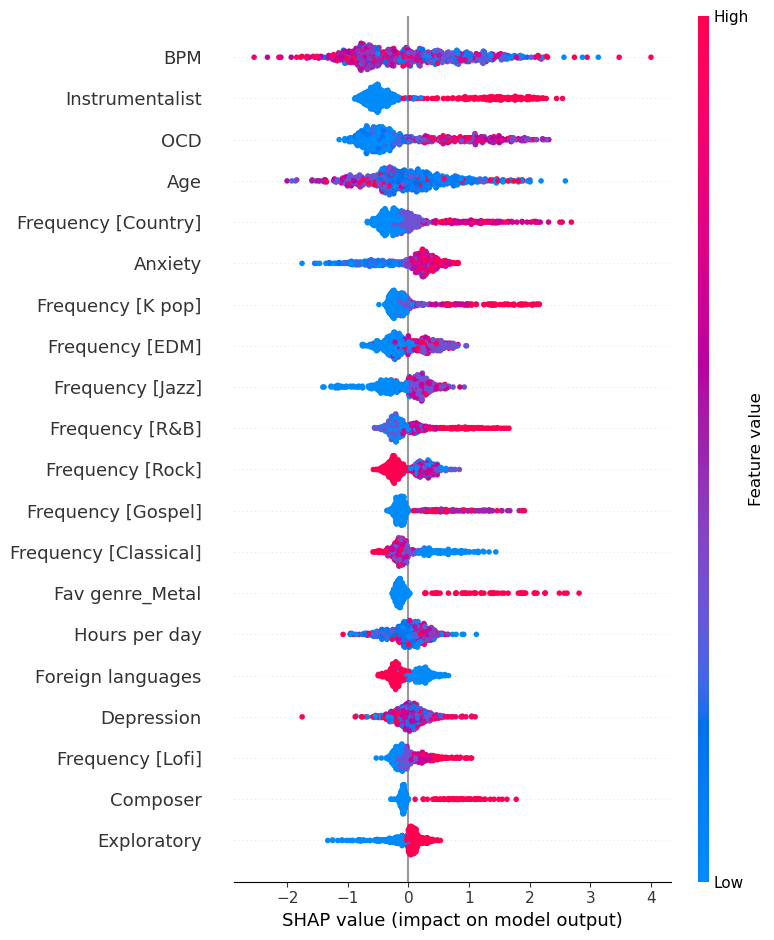

In [ ]:
# Use SHAP to investigate feature impacts

explainer = shap.TreeExplainer(model=gb_random_search.best_estimator_)
shap_values = explainer.shap_values(X_train)

summary_plot = shap.summary_plot(shap_values, X_train)
plt.show()

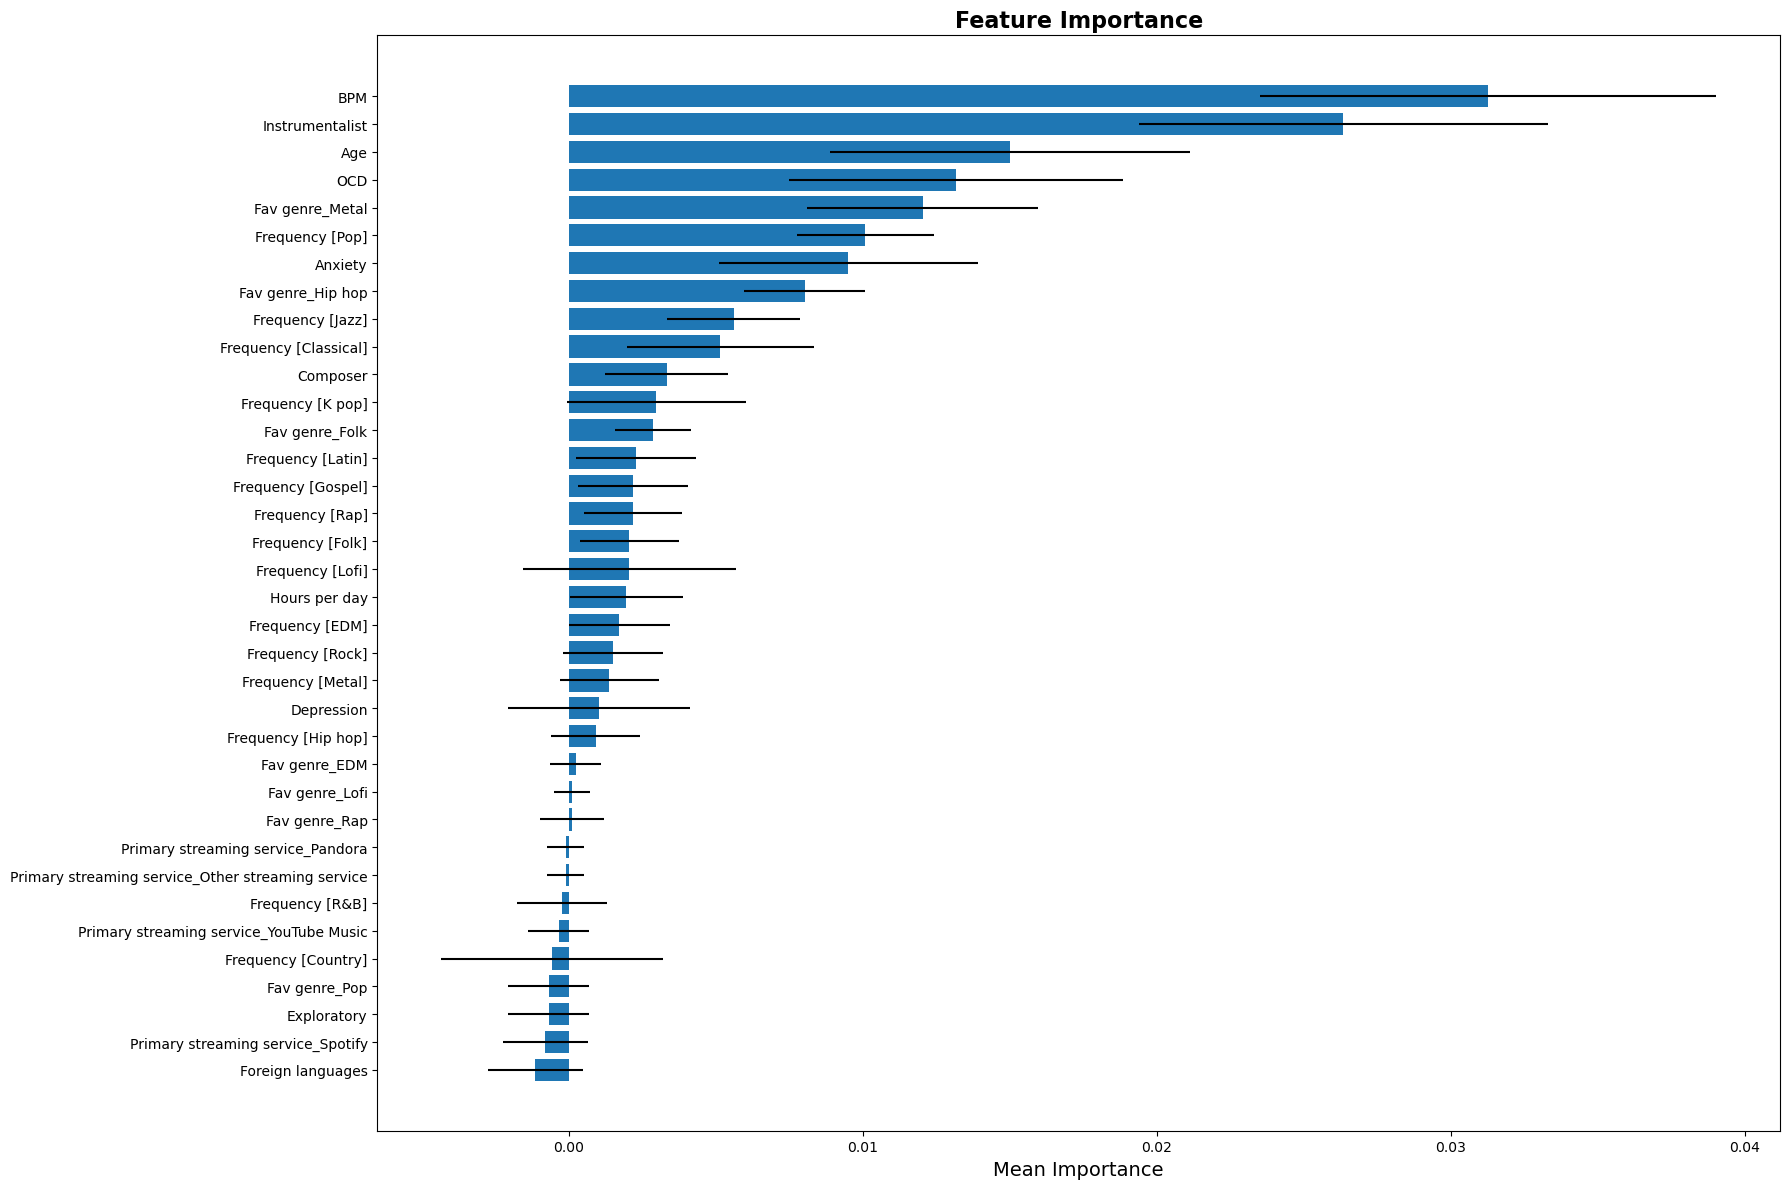

In [294]:
# Calculate feature importance using permutation importance

result = permutation_importance(
    estimator=gb_random_search.best_estimator_,
    X=X_test,
    y=y_test,
    n_repeats=30,
    random_state=RANDOM_STATE
)

importances_mean = result['importances_mean']

# Save results in dataframe and sort
importance_df = pd.DataFrame(
    {'Feature': X_test.columns, 'Importance': importances_mean, 'Std': result['importances_std']}
).sort_values(by='Importance')

# Only select non-zero importances
importance_df = importance_df[importance_df['Importance'] != 0]

# Plot
plt.figure(figsize=(18, 12))

plt.title('Feature Importance', fontsize=16, fontweight='bold')
plt.xlabel('Mean Importance', fontsize=14)
plt.barh(importance_df['Feature'], importance_df['Importance'], xerr=importance_df['Std'])

plt.tight_layout()
plt.show()

## Conclusions

- After 10-fold stratified cross-validation across five key performance metrics, both ensemble merthods-**Gradient Boosting Classifier** and **Random Forest Classifier** outperformed **Logistic Regression** in all categories.
- Since we are interested in maximizing **recall**, **Gradient Boosting Classifier** is the strongest candidate for deployment.
- The top 5 important features in predicting improvement are: BPM, Instrumentalist, Age, OCD, and Fav genre_Metal.

## Observations from SHAP Tree Explainer

- Higher BPMs **decrease** likelihood of improving.
- Being able to play an instrument **increases the likelihood** of improving following music therapy.
- People of all ages are **equally** likely to improve.
- Listening to Country, K pop, R&B, and Gospel more frequently **increases** the likelihood of feeling improvement following therapy.
- Not being exploratory when it comes to music **decreases** the likelihood of improvement.